In [121]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

In [122]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.1


In [123]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [124]:
# зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42

In [125]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [126]:
VERSION    = 16
#DIR_TRAIN  = 'kaggle kernels output itslek/baseline-sf-dst-car-price-prediction-v16 -p /path/to/dest' # подключил к ноутбуку внешний датасет
#DIR_TEST   = 'kaggle kernels output itslek/baseline-sf-dst-car-price-prediction-v16 -p /path/to/dest'
VAL_SIZE   = 0.20   # 20%

In [127]:
os.system("ls")

1

In [128]:
!ls '../input'

"ls" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [129]:
train = pd.read_csv('all_auto_ru_09_09_2020.csv') # датасет для обучения модели
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [130]:
train.head(5)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,...,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
0,Седан,AUDI,040001,бензин,1990.0,2.8 MT (174 л.с.) 4WD,4.0,1991,SEDAN MECHANICAL 2.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,200000.0,2019-10-03T08:09:11Z,NaN,100
1,Седан,AUDI,EE1D19,бензин,1982.0,1.8 MT (90 л.с.),4.0,1986,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,60000.0,2020-09-06T06:49:40Z,NaN,100
2,Универсал 5 дв.,AUDI,0000CC,бензин,1988.0,2.3 MT (136 л.с.) 4WD,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,99000.0,2020-09-02T14:04:21Z,NaN,100
3,Седан,AUDI,CACECB,бензин,1988.0,1.8 MT (90 л.с.),4.0,1989,SEDAN MECHANICAL 1.8,MECHANICAL,...,LEFT,NaN,3.0,ORIGINAL,True,NaN,65000.0,2020-08-23T17:40:09Z,NaN,100
4,Седан,AUDI,040001,бензин,1990.0,2.0 MT (101 л.с.),4.0,1991,SEDAN MECHANICAL 2.0,MECHANICAL,...,LEFT,NaN,3.0,DUPLICATE,True,NaN,100000.0,2020-09-08T09:22:07Z,NaN,100


In [131]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [132]:
#переименование руских столбцов в train
train.rename(columns = {'Комплектация' : 'complectation', 'Привод' : 'drive_unit','Руль' : 'steering_wheel',  'Состояние' : 'condition',  'Владельцы' : 'owners',  'ПТС' : 'PTS',  'Таможня' : 'сustoms',  'Владение' : 'owner_us'}, inplace = True)

In [133]:
test

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34681,седан,BMW,https://auto.ru/cars/used/sale/bmw/3er/1101369...,коричневый,NaN,Продается BMW 316i в отличном состоянии. Прода...,1.6 LTR,136 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",бензин,...,SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,3 или более,2 года и 1 месяц,Оригинал,задний,Левый,Не требует ремонта,Растаможен
34682,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101369...,чёрный,NaN,Продаётся отличный автомобиль.,2.0 LTR,190 N12,NaN,дизель,...,SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
34683,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101364...,серый,NaN,Хорошее состояние,2.5 LTR,170 N12,NaN,бензин,...,SEDAN AUTOMATIC 2.5,автоматическая,EUROPEAN,3 или более,NaN,Дубликат,задний,Левый,Не требует ремонта,Растаможен
34684,внедорожник 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/x1/11013625...,коричневый,"{""id"":""6336008"",""name"":""xDrive20d Локальная сб...",Автомобиль в идеальном состоянии . Куплен новы...,2.0 LTR,184 N12,"{""engine-proof"":true,""esp"":true,""start-stop-fu...",дизель,...,ALLROAD_5_DOORS AUTOMATIC 2.0,автоматическая,EUROPEAN,2 владельца,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен


In [134]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [135]:
#переименование руских столбцов в test
test.rename(columns = {'Комплектация' : 'complectation', 'Привод' : 'drive_unit','Руль' : 'steering_wheel',  'Состояние' : 'condition',  'Владельцы' : 'owners',  'ПТС' : 'PTS',  'Таможня' : 'сustoms',  'Владение' : 'owner_us'}, inplace = True)

In [136]:
# Пометим трейновый и тестовый датасеты и добавим столбец price к тестовому датасету заполнив его нолями:
test['price'] = 0.0
train['train'] = 1
test['train'] = 0

In [137]:
# Объединим трейновый и тестовый датасеты в один общий по принципу 'inner' (отбросив лишние столбцы):
df_car = pd.concat([train, test], join='inner', ignore_index=True)
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   bodyType              124063 non-null  object 
 1   brand                 124064 non-null  object 
 2   color                 124064 non-null  object 
 3   fuelType              124064 non-null  object 
 4   modelDate             124063 non-null  float64
 5   name                  124063 non-null  object 
 6   numberOfDoors         124063 non-null  float64
 7   productionDate        124064 non-null  int64  
 8   vehicleConfiguration  124063 non-null  object 
 9   vehicleTransmission   124063 non-null  object 
 10  engineDisplacement    124063 non-null  object 
 11  enginePower           124063 non-null  object 
 12  description           120810 non-null  object 
 13  mileage               124064 non-null  int64  
 14  drive_unit            124063 non-null  object 
 15  

In [138]:
#Переберем все столбцы по порядку и подчистим значения.
df_car.bodyType.value_counts(normalize=True)

Внедорожник 5 дв.     0.257007
Седан                 0.246592
седан                 0.105970
внедорожник 5 дв.     0.098563
Хэтчбек 5 дв.         0.069868
                        ...   
Минивэн Marco Polo    0.000008
Седан T140            0.000008
Минивэн Brawny        0.000008
Седан Gracia          0.000008
Седан 120             0.000008
Name: bodyType, Length: 192, dtype: float64

In [139]:
df_car.bodyType = df_car.bodyType.apply(lambda x: x.lower().split()[0].strip() if isinstance(x, str) else x)
df_car.bodyType.value_counts(normalize=True)

седан            0.363638
внедорожник      0.361711
хэтчбек          0.108526
лифтбек          0.045590
универсал        0.038158
минивэн          0.027583
компактвэн       0.020828
купе             0.017104
пикап            0.007327
купе-хардтоп     0.002853
кабриолет        0.002088
родстер          0.002023
фургон           0.001870
микровэн         0.000250
седан-хардтоп    0.000234
лимузин          0.000097
тарга            0.000089
фастбек          0.000032
Name: bodyType, dtype: float64

In [140]:
df_car.brand.value_counts(normalize=True)

MERCEDES      0.098272
BMW           0.095644
VOLKSWAGEN    0.093041
NISSAN        0.081934
TOYOTA        0.070423
AUDI          0.060493
MITSUBISHI    0.054617
HYUNDAI       0.046218
KIA           0.045380
SKODA         0.044711
FORD          0.038666
CHEVROLET     0.029283
VOLVO         0.028501
OPEL          0.025100
RENAULT       0.021868
HONDA         0.018773
MAZDA         0.018627
INFINITI      0.015403
LEXUS         0.015218
PEUGEOT       0.013227
LAND_ROVER    0.013082
CITROEN       0.009237
DAEWOO        0.008391
SUBARU        0.007512
SUZUKI        0.007029
SSANG_YONG    0.005779
PORSCHE       0.005747
CHERY         0.004562
JEEP          0.003893
GREAT_WALL    0.003385
DODGE         0.003369
CHRYSLER      0.002603
CADILLAC      0.002595
JAGUAR        0.002523
MINI          0.002515
GEELY         0.002378
Name: brand, dtype: float64

In [141]:
df_car.brand = df_car.brand.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_car.brand.value_counts(normalize=True)

mercedes      0.098272
bmw           0.095644
volkswagen    0.093041
nissan        0.081934
toyota        0.070423
audi          0.060493
mitsubishi    0.054617
hyundai       0.046218
kia           0.045380
skoda         0.044711
ford          0.038666
chevrolet     0.029283
volvo         0.028501
opel          0.025100
renault       0.021868
honda         0.018773
mazda         0.018627
infiniti      0.015403
lexus         0.015218
peugeot       0.013227
land_rover    0.013082
citroen       0.009237
daewoo        0.008391
subaru        0.007512
suzuki        0.007029
ssang_yong    0.005779
porsche       0.005747
chery         0.004562
jeep          0.003893
great_wall    0.003385
dodge         0.003369
chrysler      0.002603
cadillac      0.002595
jaguar        0.002523
mini          0.002515
geely         0.002378
Name: brand, dtype: float64

In [142]:
df_car.color.value_counts()

040001         25212
FAFBFB         15824
CACECB         11336
чёрный         11010
97948F         10819
0000CC          8874
белый           6133
EE1D19          4508
серебристый     4113
серый           3984
200204          3583
синий           3289
007F00          2598
C49648          1854
красный         1531
коричневый      1501
22A0F8          1398
зелёный          952
DEA522           774
660099           750
FFD600           701
бежевый          639
4A2197           606
FF8649           516
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
FFC0CB            25
розовый           13
Name: color, dtype: int64

In [143]:
# создадим и передадим словарь для переименований:
color_dict = {'040001': 'чёрный', 'FAFBFB': 'белый', '97948F': 'серый', 'CACECB': 'серебристый', '0000CC': 'синий', '200204': 'коричневый',
              'EE1D19': 'красный',  '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый', 
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}

df_car.color.replace(to_replace=color_dict, inplace=True)
df_car.color.value_counts(normalize=True)

чёрный         0.291962
белый          0.176981
серебристый    0.124524
серый          0.119317
синий          0.098038
красный        0.048676
коричневый     0.040979
зелёный        0.028614
бежевый        0.020094
голубой        0.014952
золотистый     0.008383
пурпурный      0.008093
жёлтый         0.007214
фиолетовый     0.006650
оранжевый      0.005215
розовый        0.000306
Name: color, dtype: float64

In [144]:
df_car.fuelType.value_counts(normalize=True)

бензин       0.835488
дизель       0.158845
гибрид       0.004175
электро      0.001338
газ          0.000145
универсал    0.000008
Name: fuelType, dtype: float64

In [145]:
df_car.name.value_counts()

1.6 AT (110 л.с.)     1831
2.0 AT (150 л.с.)     1749
1.6 AT (123 л.с.)     1386
1.6 MT (105 л.с.)     1181
1.6 MT (110 л.с.)      991
                      ... 
2.6d MT (83 л.с.)        1
2.4 AT (182 л.с.)        1
3.0 AT (167 л.с.)        1
1.7d MT (100 л.с.)       1
2.5d AT (190 л.с.)       1
Name: name, Length: 4774, dtype: int64

In [146]:
#признак name повторяет данные из признака vehicleConfiguration, удалим name
df_car.drop(['name'], axis=1, inplace=True)

In [147]:
df_car.numberOfDoors.value_counts()

5.0    70328
4.0    47773
2.0     3099
3.0     2861
0.0        2
Name: numberOfDoors, dtype: int64

In [148]:
df_car.numberOfDoors.value_counts(normalize=True)

5.0    0.566873
4.0    0.385070
2.0    0.024979
3.0    0.023061
0.0    0.000016
Name: numberOfDoors, dtype: float64

In [149]:
df_car.productionDate.value_counts()

2020    12784
2008     9649
2012     9428
2011     8781
2013     8089
        ...  
1924        1
1955        1
1954        1
1931        1
1951        1
Name: productionDate, Length: 80, dtype: int64

In [150]:
df_car.productionDate.value_counts(normalize=True)

2020    0.103044
2008    0.077774
2012    0.075993
2011    0.070778
2013    0.065200
          ...   
1924    0.000008
1955    0.000008
1954    0.000008
1931    0.000008
1951    0.000008
Name: productionDate, Length: 80, dtype: float64

In [151]:
df_car.vehicleConfiguration.value_counts()

SEDAN MECHANICAL 1.6              5480
SEDAN AUTOMATIC 1.6               4670
ALLROAD_5_DOORS VARIATOR 2.0      4421
ALLROAD_5_DOORS AUTOMATIC 2.0     4122
SEDAN AUTOMATIC 2.0               3840
                                  ... 
COMPACTVAN MECHANICAL 3.0            1
WAGON_5_DOORS AUTOMATIC Gracia       1
PICKUP_ONE_HALF AUTOMATIC 3.9        1
SEDAN MECHANICAL Triomphe            1
HATCHBACK_3_DOORS ROBOT 1.5d         1
Name: vehicleConfiguration, Length: 2023, dtype: int64

In [152]:
#Данный столбец vehicleConfiguration повторяет столбцы vehicleTransmission, engineDisplacement, bodyType, numberOfDoors
#Есть смысл его удалить
df_car.drop(['vehicleConfiguration'], axis=1, inplace=True)

In [153]:
df_car.vehicleTransmission.value_counts()

AUTOMATIC           49218
MECHANICAL          25264
автоматическая      19596
ROBOT                7871
механическая         7209
VARIATOR             7024
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [154]:
# создадим и передадим словарь для переименований:
transmission_dict = {'автоматическая': 'AUTOMATIC', 'механическая' : 'MECHANICAL',
                        'роботизированная' : 'ROBOT', 'вариатор' : 'VARIATOR'}

df_car.vehicleTransmission.replace(to_replace=transmission_dict, inplace=True)
df_car.vehicleTransmission = df_car.vehicleTransmission.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_car.vehicleTransmission.value_counts(normalize=True)

automatic     0.554670
mechanical    0.261746
robot         0.094734
variator      0.088850
Name: vehicleTransmission, dtype: float64

In [155]:
df_car.engineDisplacement.value_counts(normalize=True)

1.6         0.137285
2.0         0.108380
2.0 LTR     0.059575
1.4         0.045533
1.8         0.041124
              ...   
3.0hyb      0.000008
N46         0.000008
Prime       0.000008
Aircross    0.000008
Marco       0.000008
Name: engineDisplacement, Length: 589, dtype: float64

In [156]:
# Посмотрим количество уникальных значений в столбце
df_car.engineDisplacement.nunique()

589

In [157]:
def engineDisplacement_to_float(item):
    try:
        return float(item)
    except:
        return 2.0 # наиболее часто встречающийся объем двигателя
    
df_car.engineDisplacement = df_car.engineDisplacement.apply(lambda x: (x.replace(" LTR", "")) if isinstance(x, str) else x)
df_car.engineDisplacement = df_car.engineDisplacement.apply(engineDisplacement_to_float)

In [158]:
df_car.engineDisplacement.value_counts(normalize=True)

2.0      0.331541
1.6      0.177370
1.8      0.068119
1.4      0.058712
2.5      0.043236
           ...   
100.0    0.000008
210.0    0.000008
8.2      0.000008
116.0    0.000008
318.0    0.000008
Name: engineDisplacement, Length: 126, dtype: float64

In [159]:
# Посмотрим количество уникальных значений в столбце
df_car.engineDisplacement.nunique()

126

In [160]:
df_car.enginePower.value_counts(normalize=True)

150.0      0.056890
249.0      0.029993
140.0      0.023359
105.0      0.019023
123.0      0.018555
             ...   
11.0       0.000008
44 N12     0.000008
251.0      0.000008
127 N12    0.000008
321 N12    0.000008
Name: enginePower, Length: 711, dtype: float64

In [161]:
def enginePower_to_float(item):
    try:
        return float(item)
    except:
        return float(150) # наиболее часто встречающаяся мошьность

df_car.enginePower = df_car.enginePower.apply(lambda x: x.split()[0].strip() if isinstance(x, str) else x)
df_car.enginePower = df_car.enginePower.apply(enginePower_to_float)
df_car.enginePower.value_counts(normalize=True)

150.0    0.070585
249.0    0.043760
140.0    0.030952
105.0    0.026720
110.0    0.025245
           ...   
11.0     0.000008
513.0    0.000008
570.0    0.000008
236.0    0.000008
437.0    0.000008
Name: enginePower, Length: 398, dtype: float64

In [162]:
df_car.description.head(5)

0     Машина  в приличном состоянии ,не гнилая не р...
1    Машина в оригинале не гнилая все вопросы по те...
2    ПТС Оригинал!\nПолный комплект ключей!\nПо рез...
3                                                  NaN
4    Машина не гнилая, дыр нет, днище целое, даже в...
Name: description, dtype: object

In [163]:
# Столбец description не будет нести ни какой пользы для модели, удаляем
df_car.drop(['description'], axis=1, inplace=True)

In [164]:
df_car.mileage

0         350000
1         173424
2         230000
3         240000
4         300000
           ...  
124059    115000
124060     98000
124061    360000
124062     90500
124063    240000
Name: mileage, Length: 124064, dtype: int64

In [165]:
df_car.mileage.value_counts(normalize=True)
#Видим, что много новых машин, почти 11%

0         0.109524
200000    0.012671
150000    0.011526
180000    0.010027
160000    0.009697
            ...   
120813    0.000008
231399    0.000008
149471    0.000008
155612    0.000008
6141      0.000008
Name: mileage, Length: 24379, dtype: float64

In [166]:
df_car.drive_unit.value_counts(normalize=True)

передний    0.506839
полный      0.403190
задний      0.089970
Name: drive_unit, dtype: float64

In [167]:
df_car.steering_wheel.value_counts(normalize=True)

LEFT      0.705999
Левый     0.268305
RIGHT     0.014420
Правый    0.011276
Name: steering_wheel, dtype: float64

In [168]:
# создадим и передадим словарь для переименований:
steering_wheel_dict = {'Левый': 'LEFT', 'Правый' : 'RIGHT'}

df_car.steering_wheel.replace(to_replace=steering_wheel_dict, inplace=True)
df_car.steering_wheel = df_car.steering_wheel.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_car.steering_wheel.value_counts(normalize=True)

left     0.974304
right    0.025696
Name: steering_wheel, dtype: float64

In [169]:
df_car.condition.value_counts(normalize=True)

Не требует ремонта    1.0
Name: condition, dtype: float64

In [170]:
# Столбец condition не будет нести ни какой пользы для модели, удаляем
df_car.drop(['condition'], axis=1, inplace=True)

In [171]:
df_car.owners.value_counts(normalize=True)

3.0            0.328107
2.0            0.190141
1.0            0.167783
3 или более    0.144439
1 владелец     0.085620
2 владельца    0.083910
Name: owners, dtype: float64

In [172]:
# создадим и передадим словарь для переименований:
owners_dict = {'1 владелец': '1.0', '1\xa0владелец': '1.0','2\xa0владельца': '2.0',
               '2 владельца': '2.0', '3 или более' : '3.0', 'NaN':'1.0'}

df_car.owners.replace(to_replace=owners_dict, inplace=True)
df_car.owners = df_car.owners.apply(lambda x: float(x) if isinstance(x, str) else x)
df_car.owners.value_counts(normalize=True)

3.0    0.472546
2.0    0.274050
1.0    0.253403
Name: owners, dtype: float64

In [173]:
df_car.PTS.value_counts(normalize=True)

ORIGINAL     0.635374
Оригинал     0.243311
DUPLICATE    0.084235
Дубликат     0.037081
Name: PTS, dtype: float64

In [174]:
# создадим и передадим словарь для переименований:
PTS_dict = {'Оригинал': 'ORIGINAL', 'Дубликат' : 'DUPLICATE'}

df_car.PTS.replace(to_replace=PTS_dict, inplace=True)
df_car.PTS = df_car.PTS.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_car.PTS.value_counts(normalize=True)

original     0.878684
duplicate    0.121316
Name: PTS, dtype: float64

In [175]:
df_car.сustoms.value_counts(normalize=True)

True          0.720418
Растаможен    0.279582
Name: сustoms, dtype: float64

In [176]:
# Столбец сustoms бинарен, но в данном случае не будет нести ни какой пользы для модели, удаляем
df_car.drop(['сustoms'], axis=1, inplace=True)

In [177]:
df_car.owner_us.value_counts(normalize=True)

{'year': 2018, 'month': 10}    0.012064
{'year': 2019, 'month': 8}     0.011991
{'year': 2018, 'month': 8}     0.011943
{'year': 2018, 'month': 9}     0.011603
{'year': 2018, 'month': 11}    0.011482
                                 ...   
{'year': 1996, 'month': 1}     0.000024
{'year': 1998, 'month': 5}     0.000024
{'year': 2002, 'month': 10}    0.000024
{'year': 1999, 'month': 9}     0.000024
{'year': 1999, 'month': 5}     0.000024
Name: owner_us, Length: 565, dtype: float64

In [178]:
# Столбец owner_us не будет нести ни какой пользы для модели, к томуже более 50% пропусков в данных, удаляем
df_car.drop(['owner_us'], axis=1, inplace=True)

In [179]:
df_car.price.value_counts(normalize=True)

0.0           0.280509
450000.0      0.009802
350000.0      0.008451
250000.0      0.008039
550000.0      0.007820
                ...   
2701000.0     0.000008
3995300.0     0.000008
2841150.0     0.000008
17600000.0    0.000008
9295795.0     0.000008
Name: price, Length: 8169, dtype: float64

In [180]:
df_car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124064 entries, 0 to 124063
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             124063 non-null  object 
 1   brand                124064 non-null  object 
 2   color                124064 non-null  object 
 3   fuelType             124064 non-null  object 
 4   modelDate            124063 non-null  float64
 5   numberOfDoors        124063 non-null  float64
 6   productionDate       124064 non-null  int64  
 7   vehicleTransmission  124063 non-null  object 
 8   engineDisplacement   124063 non-null  float64
 9   enginePower          124063 non-null  float64
 10  mileage              124064 non-null  int64  
 11  drive_unit           124063 non-null  object 
 12  steering_wheel       124064 non-null  object 
 13  owners               110476 non-null  float64
 14  PTS                  123702 non-null  object 
 15  price            

In [181]:
# Посмотрим на количество дубликатов и удалим их:
df_car.drop_duplicates(inplace=True)
df_car.shape

(117454, 17)

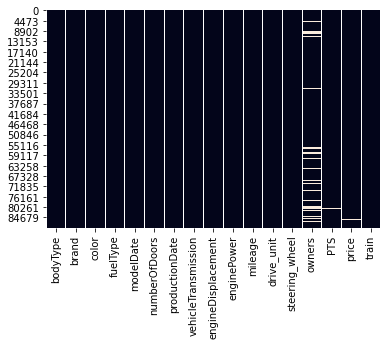

In [182]:
# Посмотрим теперь где поконкретнее пропуски в train порции.
sns.heatmap(df_car[df_car.train == 1].isna(), cbar=False);

In [183]:
# Посмотрим количество уникальных значений в каждом столбце
df_car.nunique(dropna=False)

bodyType                  19
brand                     36
color                     16
fuelType                   6
modelDate                 79
numberOfDoors              6
productionDate            80
vehicleTransmission        5
engineDisplacement       127
enginePower              399
mileage                24379
drive_unit                 4
steering_wheel             2
owners                     4
PTS                        3
price                   8170
train                      2
dtype: int64

In [184]:
# Сгруппируем признаки по типам
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'modelDate', 'productionDate']
bin_cols = ['steering_wheel']
cat_cols = ['bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'drive_unit', 'owners', 'numberOfDoors', 'PTS']
target_cols = ['price']

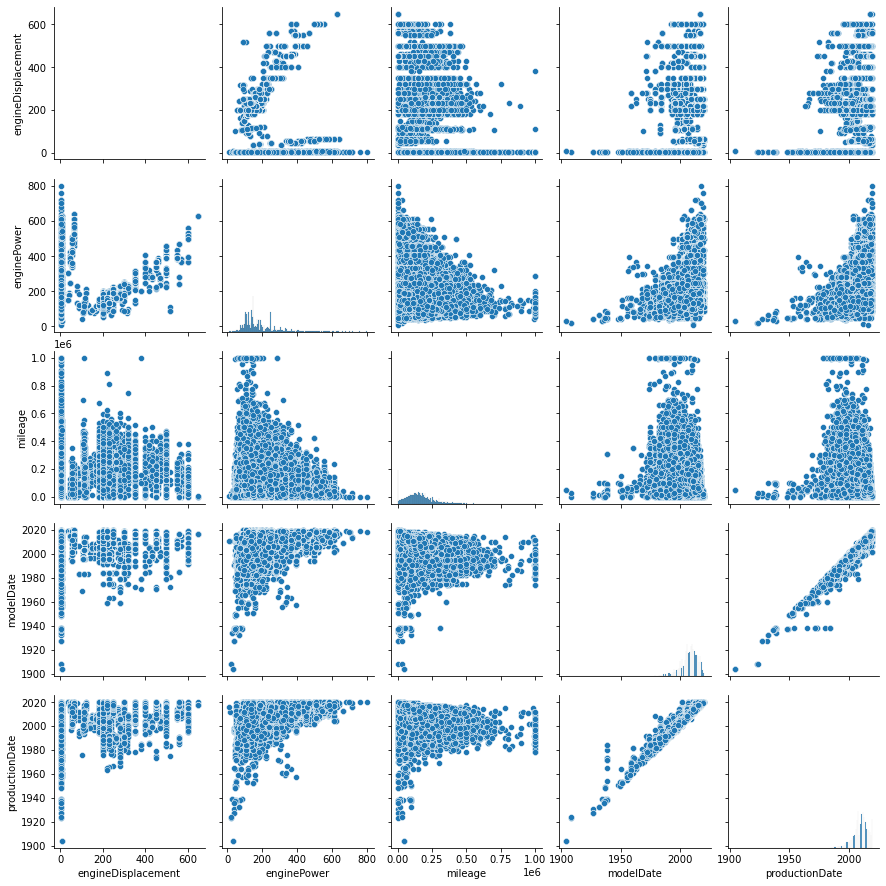

In [185]:
# посмотрим на корреляцию числовых признаков
sns.pairplot(df_car[num_cols])

In [186]:
# Посмотрим на общую информацию
df_car[num_cols].describe()

,engineDisplacement,enginePower,mileage,modelDate,productionDate
count,117453.000000,117453.000000,117454.000000,117453.000000,117454.000000
mean,21.152380,175.132342,149588.680496,2007.653410,2009.915984
std,79.107332,85.807138,100480.153867,7.306876,6.909250
min,0.700000,11.000000,0.000000,1904.000000,1904.000000
25%,1.600000,115.000000,81000.000000,2004.000000,2007.000000
50%,2.000000,150.000000,140000.000000,2009.000000,2011.000000
75%,2.400000,210.000000,201100.000000,2013.000000,2014.000000
max,650.000000,800.000000,1000000.000000,2020.000000,2020.000000


In [187]:
# Столбцы modelDate и productionDate имеют сильную корреляцию
# Оставим признак productionDate, т. к. стандартное отклонение у этого признака меньше
df_car.drop(['modelDate'], axis=1, inplace=True)

In [188]:
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'productionDate']

<AxesSubplot:>

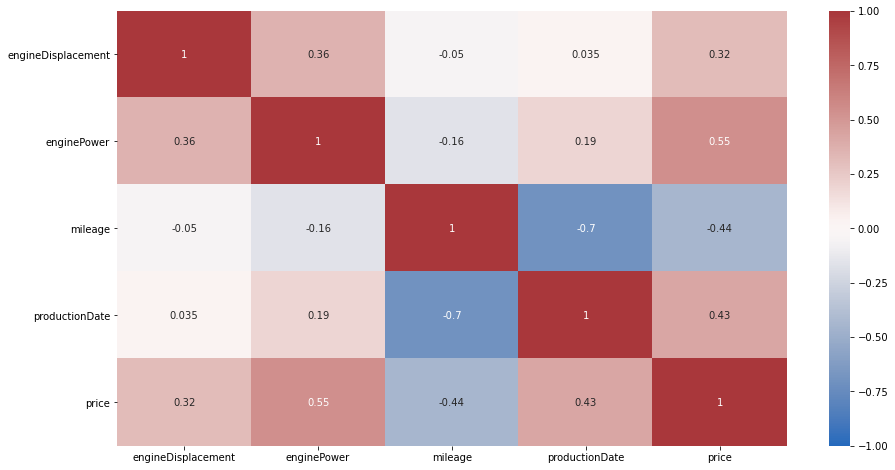

In [189]:
# Посмотрим на корреляцию числовых признаков с ценой (нашим таргетом)
plt.figure(figsize=(15, 8));
sns.heatmap(df_car[df_car.train == 1][num_cols + ['price']].corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')

In [190]:
# все признаки имеют сильную корреляцию с price
# Но признак engineDisplacement имеет слабую корреляцию с другими признаками, удалим его
df_car.drop(['engineDisplacement'], axis=1, inplace=True)

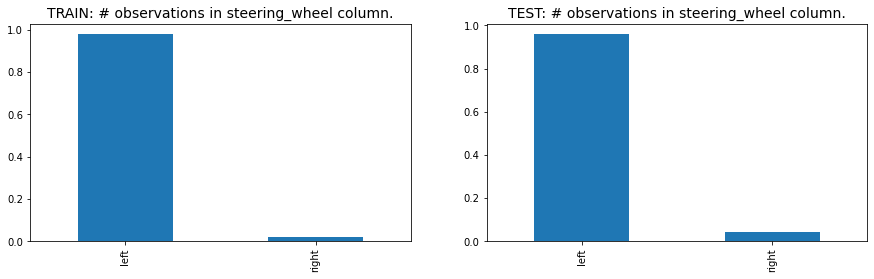

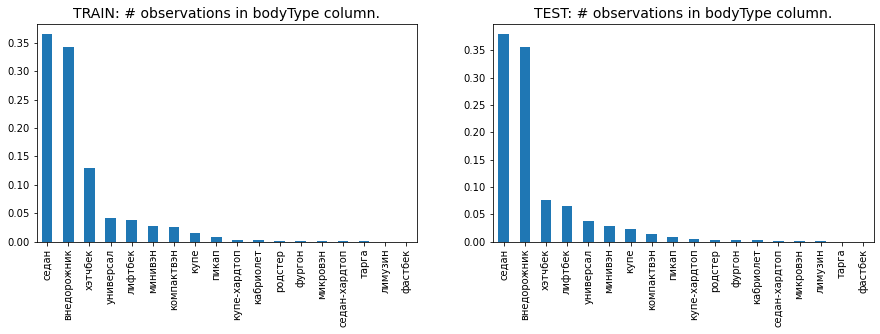

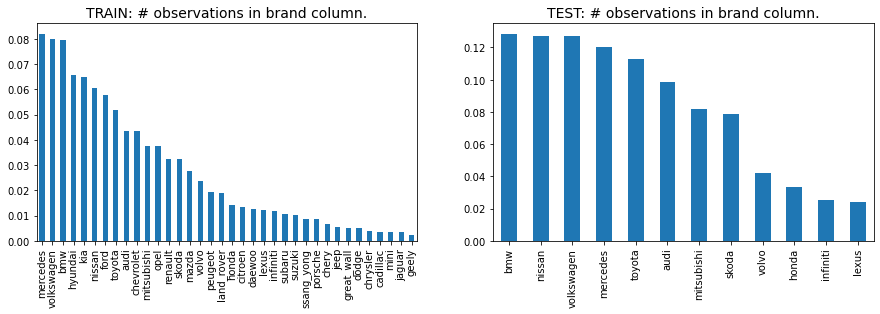

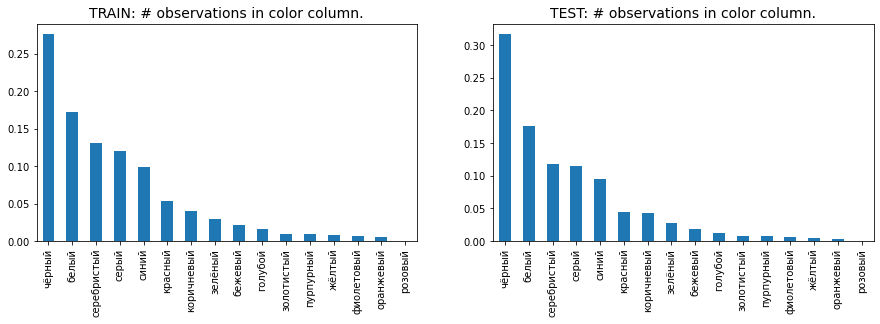

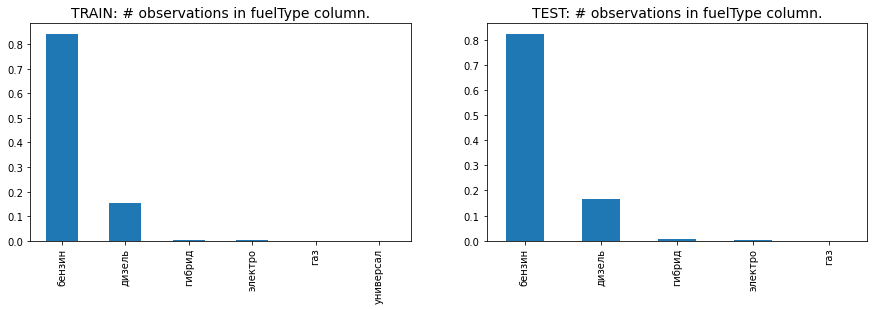

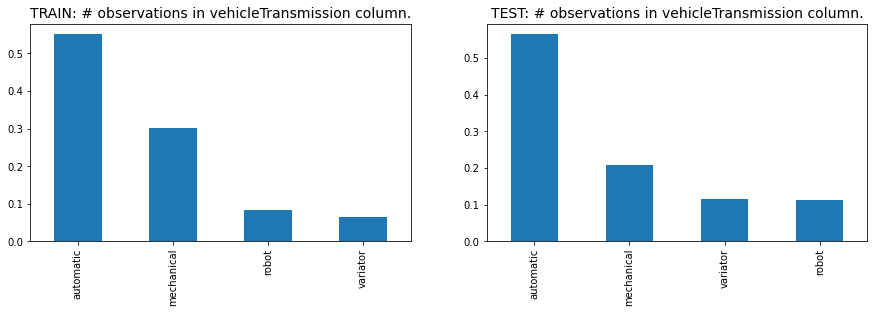

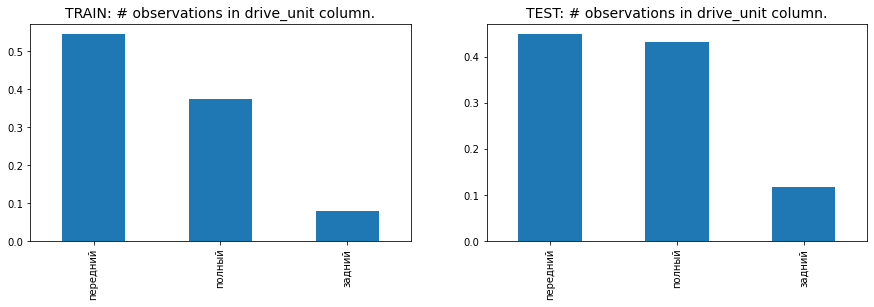

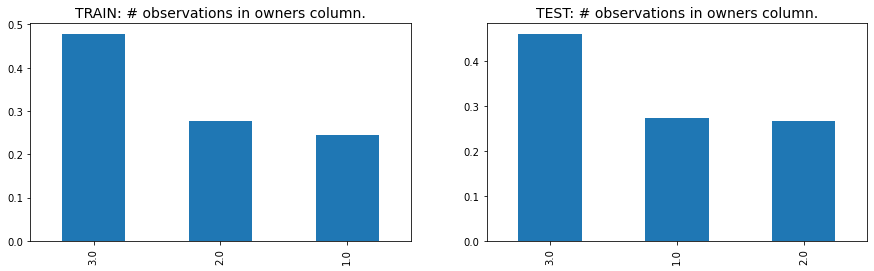

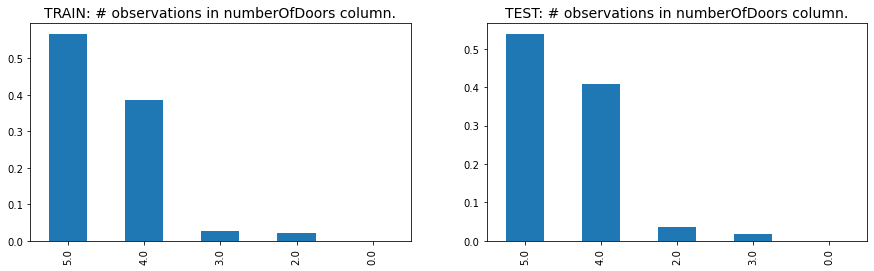

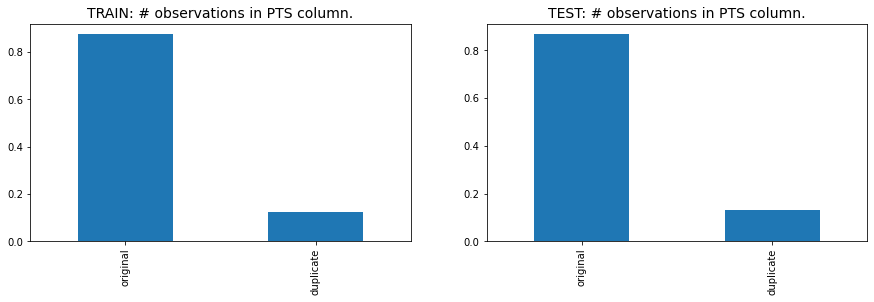

In [191]:
# Посмотрим на баланс в выборках
for col in (bin_cols + cat_cols):
    if col not in ['model_name']:
        fig, ax = plt.subplots(figsize=(15, 4), ncols=2, nrows=1)
        ax[0].set_title(f'TRAIN: # observations in {col} column.', fontdict={'fontsize': 14})
        df_car[df_car.train == 1][col].value_counts(normalize=True).plot(kind='bar', ax=ax[0])
        ax[1].set_title(f'TEST: # observations in {col} column.', fontdict={'fontsize': 14})
        df_car[df_car.train == 0][col].value_counts(normalize=True).plot(kind='bar', ax=ax[1])

In [192]:
# Есть перекос в марках автомобилей, в test части представлено всего 12 марок
# в целом считаю, что можно перейти к моделированию
df_car.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117454 entries, 0 to 124063
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   bodyType             117453 non-null  object 
 1   brand                117454 non-null  object 
 2   color                117454 non-null  object 
 3   fuelType             117454 non-null  object 
 4   numberOfDoors        117453 non-null  float64
 5   productionDate       117454 non-null  int64  
 6   vehicleTransmission  117453 non-null  object 
 7   enginePower          117453 non-null  float64
 8   mileage              117454 non-null  int64  
 9   drive_unit           117453 non-null  object 
 10  steering_wheel       117454 non-null  object 
 11  owners               109765 non-null  float64
 12  PTS                  117116 non-null  object 
 13  price                117044 non-null  float64
 14  train                117454 non-null  int64  
dtypes: float64(4), in

In [193]:
# Сделаем Label Encoding для бинарных и категоральных признаков
for colum in ['steering_wheel','bodyType', 'brand', 'color', 'fuelType', 'vehicleTransmission', 'drive_unit', 'owners', 'numberOfDoors', 'PTS']:
    df_car[colum] = df_car[colum].astype('category').cat.codes

cols_to_encode = list(set(df_car.columns) & set(cat_cols))
for colum in cols_to_encode:
    df_car[colum] = df_car[colum].astype('category').cat.codes

In [194]:
#Копируем датасет для удаления строк имеющих пропущенные значения
df_car_copy = df_car

In [195]:
df_car_copy = df_car_copy.dropna(axis=0)

In [196]:
X = df_car_copy.query('train == 1').drop(['train'], axis=1)
y = df_car_copy.query('train == 1')['price']
X_sub = df_car_copy.query('train == 0').drop(['train'], axis=1)

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, random_state=RANDOM_SEED)

In [198]:
#Model 1: "наивная" модель
tmp_train = X_train.copy()
tmp_train['price'] = y_train

In [199]:
# Находим median по экземплярам enginePower в трейне и размечаем тест
predict = X_test['enginePower'].map(tmp_train.groupby('enginePower')['price'].median())

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 59.15%


In [200]:
# Model 2 : CatBoost
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [201]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 0.88%


In [202]:
#Точность модели по метрике MAPE: 0.88%